In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

In [2]:
inputFiles = ['./pp2C1X1_0j/Events/run_05/c1x1_10ns_13000GeV_0j2_djrs.dat',
              './pp2C1X1_1j/Events/run_05/c1x1_10ns_13000GeV_1j2_djrs.dat',
              './pp2C1X1_2j/Events/run_01/c1x1_10ns_13000GeV_2j_djrs.dat']

### Get Qcut

In [3]:
qcut = None
for inputFile in inputFiles:
    dirname = os.path.dirname(inputFile)
    filename = os.path.basename(inputFile).replace('_djrs.dat','_merged_xsecs.txt')
    matchFile = os.path.join(dirname,filename)
    with open(matchFile,'r') as f:
        qcutNew = eval(f.readlines()[1].split()[0])
    if qcut is None:
        qcut = qcutNew
    elif qcutNew != qcut:
        print('!!!Using files with distinct qcut values!!!')
    print('qcut = %1.2f' %qcut)

qcut = 150.00
qcut = 150.00
qcut = 150.00


### Get histograms

In [4]:
histsDict = {}

for inputFile in inputFiles:
    with open(inputFile,'r') as f:
        data = f.read()
    data = data.split('<histogram>')[1:]
    for block in data:
        block = block.split('<\\histogram>')[0]
        block = block.split('\n')
        header = block[0]
        pts = np.array([[eval(x) for x in l.split() if x] for l in block[1:] if l.strip()])
        label = header.split('|')
        label = (label[0].split()[1].replace('"',''),label[-1].replace('"',''))
        if not label[0] in histsDict:
            histsDict[label[0]] = {}
        if not label[1] in histsDict[label[0]]:
            histsDict[label[0]].update({label[1] : pts})
        else:
            histsDict[label[0]][label[1]][:,-2] += pts[:,-2]
            histsDict[label[0]][label[1]][:,-1] += pts[:,-1]

In [5]:
### Remove plots for DJR larger than nJetmax:
nJetmax = max([eval(x.split('@')[1]) for x in list(histsDict.values())[0].keys()])
for label in list(histsDict.keys()):
    if eval(label.strip()[-1]) > nJetmax:
        histsDict.pop(label)

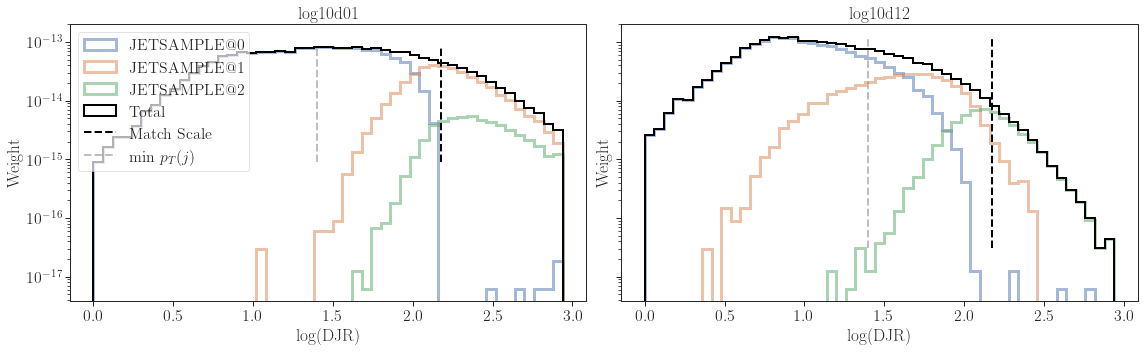

In [7]:
nplots = len(histsDict)
if nplots > 1:
    fig,axarr = plt.subplots(figsize=(16,5*int(nplots/2.)),nrows=int(nplots/2.),ncols=2,
                         sharey=True)
else:
    fig,axarr = plt.subplots(figsize=(8,5),nrows=1,ncols=1,
                         sharey=True)
    axarr = np.array([axarr])
nbins = 2 # Controls how many bins are merged together (from the original histogram)
for iplot,label in enumerate(histsDict):
    ax = axarr.ravel()[iplot]
    total = None
    for sample,pts in histsDict[label].items():
        binc,bins,_ = ax.hist(pts[:,0],weights=pts[:,-2],
                 label=sample,bins=pts[:,0][::nbins],
                 histtype='step',linewidth=3,alpha=0.5)
        if total is None:
            total = np.zeros(len(bins)-1)
        total += binc    
    ax.hist(bins[:-1],weights=total,bins=bins,label='Total',histtype='step',color='black',linewidth=2)    
    ax.vlines(x=np.log10(qcut),ymin=total.min(),ymax=total.max(),linestyle='--',
              color='black',linewidth=2,label='Match Scale')
    
    ax.vlines(x=np.log10(25.0),ymin=total.min(),ymax=total.max(),linestyle='--',
              color='gray',linewidth=2,label=r'min $p_T(j)$',alpha=0.5)
    
    ax.set_xlabel('log(DJR)')
    ax.set_ylabel('Weight')
    ax.set_yscale('log')
    ax.set_title(label)
    if iplot == 0:    
        ax.legend(loc='upper left',framealpha=0.7)
plt.tight_layout()
# plt.savefig(inputFile.replace('.dat','.png'))
plt.show()